# Defs and imports

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import eios_data as eios_file
import eios_analyse as eios_analyse

In [12]:
def read_EIOS_file(filename, sort=False, skip_first=False, fluo_cut = 0, hist_analysis = False, do_plot = True):
    dat, xml = eios_file.read(filename, sort, skip_first)
    x0 = dat[0]['x']
    y0 = dat[0]['y']
    yerr0 = dat[0]['error']
    x1 = dat[1]['x']
    y1 = dat[1]['y']
    yerr1 = dat[1]['error']
    hists = dat[0]['hists']
    
    x0clean = [];
    y0clean = [];
    yerr0clean = [];
    histsclean = [];
    x1clean = [];
    y1clean = [];
    yerr1clean = [];
    x0bad = [];
    y0bad = [];
    yerr0bad = [];
    histsbad = [];
    x1bad = [];
    y1bad = [];
    yerr1bad = [];    
    for tp in range(0,len(x1)):
        if y1[tp] > fluo_cut:
            x0clean.append(x0[tp])
            y0clean.append(y0[tp])
            yerr0clean.append(yerr0[tp])
            histsclean.append(hists[tp])
            x1clean.append(x1[tp])
            y1clean.append(y1[tp])
            yerr1clean.append(yerr1[tp])     
        else: 
            x0bad.append(x0[tp])
            y0bad.append(y0[tp])
            yerr0bad.append(yerr0[tp])
            histsbad.append(hists[tp])
            x1bad.append(x1[tp])
            y1bad.append(y1[tp])
            yerr1bad.append(yerr1[tp])               

    if do_plot == True:
        fig, ax = plt.subplots(figsize=(18,6));
        ax.errorbar(x0clean, y0clean, yerr = yerr0clean, linestyle = "--", marker = "o");
        ax.errorbar(x1clean, y1clean, yerr = yerr1clean, linestyle = "--", marker = "o");
        ax.errorbar(x0bad, y0bad, yerr = yerr0bad, linestyle = "None", marker = "o");
        ax.errorbar(x1bad, y1bad, yerr = yerr1bad, linestyle = "None", marker = "o");
        ax.plot([min(x0),max(x0)],[fluo_cut,fluo_cut]);
        ax.set_ylabel('Fluo.', fontsize=10);    
    
    if hist_analysis == True:
        y0out, y0out_err = eios_analyse.fit_direct(histsclean, do_plot = do_plot)
    else: 
        y0out = y0clean
        y0out_err = yerr0clean
        
    if do_plot == True:
        fig, ax = plt.subplots(figsize=(18,6));
        ax.errorbar(x0clean, y0out, yerr = y0out_err, linestyle = "None", marker = "o");
        ax.set_ylabel('$P_\Downarrow$', fontsize=10);  
        ax.set_ylim(0,1);

    return x0clean,y0out,y0out_err

In [13]:
%matplotlib inline
#%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy.constants as cst
#import sympy as sym
import datetime as dt
import time

from IPython.display import HTML
from matplotlib import animation

In [14]:
from math import factorial
from scipy.special import eval_genlaguerre

amu = 1.66053892099999983243145829272e-27;
hbar = 1.05457172533628960870683374522e-34;
MHz = 1e6;
nm = 1e-9;
def LDparameter(fmode, angle):
    return np.sqrt(2)*np.abs(np.cos(angle/180*np.pi))*2*np.pi/(280*nm)*np.sqrt(hbar/(2*25*amu * 2* np.pi * fmode*MHz))

def OmegaOC(n0,n1, Omega0, LDparameter):
    dn = n1-n0;
    if (dn>0):
        tOmega = Omega0 * np.exp(-0.5*LDparameter**2) * LDparameter**dn * np.sqrt(factorial(n0)/factorial(n1)) * eval_genlaguerre(n0,dn,LDparameter**2)
    elif (dn<0):
        tOmega = Omega0 * np.exp(-0.5*LDparameter**2) * LDparameter**np.abs(dn) * np.sqrt(factorial(n1)/factorial(n0)) * eval_genlaguerre(n1,np.abs(dn),LDparameter**2)
    else:
        tOmega = Omega0 * np.exp(-0.5*LDparameter**2) * eval_genlaguerre(n0,dn,LDparameter**2)
    return tOmega

def OCFlop1M(LDparameter, Fockdist, Rabi0, gamma, dn, tlist):
    values=[];
    for tt in tlist:
        if dn > 0: tsum = 0;
        else: tsum = 1;
        if (dn < 0): n0 = np.abs(dn)
        else: n0 = 0
        for tn in np.linspace(n0,Fockdist[-1][0],len(Fockdist)-n0):
            trate = np.abs(OmegaOC(int(tn), int(tn+dn), Rabi0, LDparameter));
            if dn > 0:
                tsum = tsum + np.abs(Fockdist[int(tn)][1])*np.sin(np.pi*trate*tt)**2
            else: tsum = tsum - np.abs(Fockdist[int(tn)][1])*np.sin(np.pi*trate*tt)**2
        tsumdec = 0.5 + np.exp(-gamma * tt)*(tsum - 0.5)
        values.append(tsumdec)
    return values

def OCFlop1Mdec(LDparameter, Fockdist, Rabi0, gamma, lim, dn, tlist):
    values=[];
    for tt in tlist:
        if dn > 0: tsum = 0;
        else: tsum = 1;
        if (dn < 0): n0 = np.abs(dn)
        else: n0 = 0
        for tn in np.linspace(n0,Fockdist[-1][0],len(Fockdist)-n0):
            trate = np.abs(OmegaOC(int(tn), int(tn+dn), Rabi0, LDparameter));
            if dn > 0:
                tsum = tsum + np.abs(Fockdist[int(tn)][1])*np.sin(np.pi*trate*tt)**2
            else: tsum = tsum - np.abs(Fockdist[int(tn)][1])*np.sin(np.pi*trate*tt)**2
        tsumdec = lim + np.exp(-gamma * tt)*(tsum - lim)
        values.append(tsumdec)
    return values

def thermaldist(nmax, nbar):
    tdist = [];
    for n in range(0,nmax+1):
        tdist.append([ n , nbar**n / (1+nbar)**(n+1) ])          # correct!
    return tdist

def displacedthermaldist(nmax, nthermal, ncoherent):
    thermalpops = [];
    for n in range(0,nmax+1):
        thermalpops.append([ n , nthermal**n / (1+nthermal)**(n+1) ]);
    displacednumberstates = [];
    for n in range(0,nmax+1):
        tdisplacednumberstate = displace(nmax+1, ncoherent) * basis(nmax+1,n);
        displacednumberstates.append((tdisplacednumberstate*tdisplacednumberstate.dag()).diag());
    outputdist = [];
    for tF in range(0,nmax+1):
        tnpop = [];
        for tn in range(0,nmax+1):
            thermalfact = thermalpops[tn][1];
            tpop = np.real(displacednumberstates[tF][tn]) * thermalfact;
            tnpop.append(tpop);
        outputdist.append([tF, sum(tnpop)]);
    return outputdist

def squeezeddisplacedthermaldist(nmax, nthermal, ncoherent, nsqueezed):
    thermalpops = [];
    for n in range(0,nmax+1):
        thermalpops.append([ n , nthermal**n / (1+nthermal)**(n+1) ]);
    displacednumberstates = [];
    for n in range(0,nmax+1):
        tdisplacednumberstate = squeeze(nmax+1, nsqueezed) * displace(nmax+1, ncoherent) * basis(nmax+1,n);
        displacednumberstates.append((tdisplacednumberstate*tdisplacednumberstate.dag()).diag());
    outputdist = [];
    for tF in range(0,nmax+1):
        tnpop = [];
        for tn in range(0,nmax+1):
            thermalfact = thermalpops[tn][1];
            tpop = np.real(displacednumberstates[tF][tn]) * thermalfact;
            tnpop.append(tpop);
        outputdist.append([tF, sum(tnpop)]);
    return outputdist

def displacedsqueezedthermaldist(nmax, nthermal, nsqueezed, ncoherent):
    thermalpops = [];
    for n in range(0,nmax+1):
        thermalpops.append([ n , nthermal**n / (1+nthermal)**(n+1) ]);
    displacednumberstates = [];
    for n in range(0,nmax+1):
        tdisplacednumberstate = displace(nmax+1, ncoherent) * squeeze(nmax+1, nsqueezed) * basis(nmax+1,n);
        displacednumberstates.append((tdisplacednumberstate*tdisplacednumberstate.dag()).diag());
    outputdist = [];
    for tF in range(0,nmax+1):
        tnpop = [];
        for tn in range(0,nmax+1):
            thermalfact = thermalpops[tn][1];
            tpop = np.real(displacednumberstates[tF][tn]) * thermalfact;
            tnpop.append(tpop);
        outputdist.append([tF, sum(tnpop)]);
    return outputdist

def normalizefockdist(fockdist):
    tsum = sum([item[1] for item in fockdist])
    normalizedfockdist = []
    for item in fockdist:
        itemnorm = [item[0],item[1]/tsum]
        normalizedfockdist.append(itemnorm)
    return normalizedfockdist    

def thermalBSB(t, nbar):
    return OCFlop1M(tLD, thermal_dist(tnmax, nbar), tRabi, 0, 1, [t])[0]
def thermalRSB(t, nbar):
    return OCFlop1M(tLD, thermal_dist(tnmax, nbar), tRabi, 0, -1, [t])[0]

def displacedBSB(t, nbar, alpha):
    return OCFlop1M(tLD, displacedthermaldist(tnmax, nbar, alpha), tRabi, 0, 1, [t])[0]
def displacedRSB(t, nbar, alpha):
    return OCFlop1M(tLD, displacedthermaldist(tnmax, nbar, alpha), tRabi, 0, -1, [t])[0]

In [15]:
def normalizefockdist(fockdist):
    tsum = sum([item[1] for item in fockdist])
    normalizedfockdist = []
    for item in fockdist:
        itemnorm = [item[0],item[1]/tsum]
        normalizedfockdist.append(itemnorm)
    return normalizedfockdist

In [16]:
from iminuit import Minuit
from matplotlib import pyplot as plt

# Fitting

In [17]:
path = '/home/matt/Dropbox/PhD/Messungen/EIOS'
keys=['16_14_16', '16_14_17']
fn = [];
for key in keys:
    tfn = eios_file.find_file(path,key,year='2018',month='10_Oktober',day='08',cat='EU_switch_RF',first=False)
    if len(tfn) == 1: 
        fn.append(tfn[0])
    elif len(tfn) == 2: 
        fn.append(tfn[0])
        fn.append(tfn[1])
    else: print(len(tfn))
print(len(fn)) 
print(len(keys))

2
2


Counter #0 [101] (4849..7014/9213)
Counter #1 [101] (7014..9211/9213)
[0.23265318 9.03637969 0.78431898]


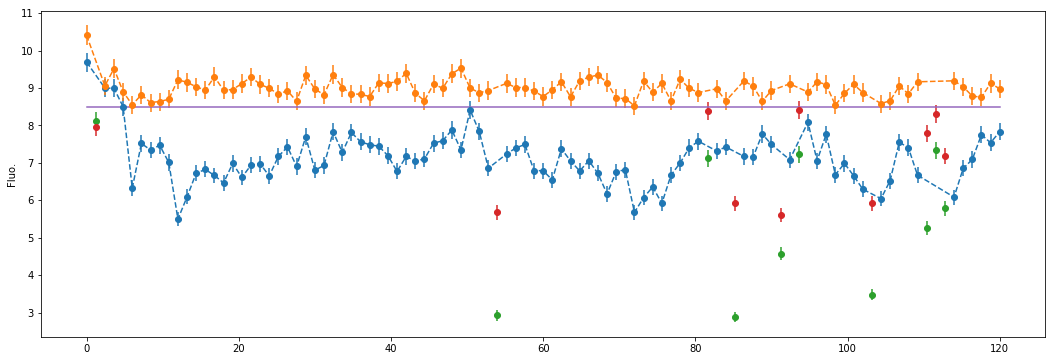

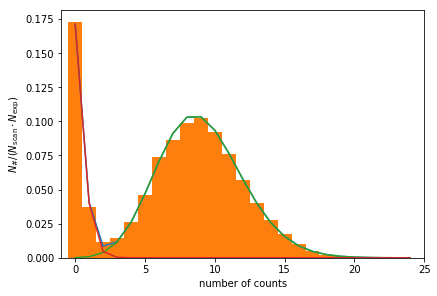

Counter #0 [101] (4849..6928/9126)
Counter #1 [101] (6928..9124/9126)
[0.19415593 8.89669954 0.51609638]


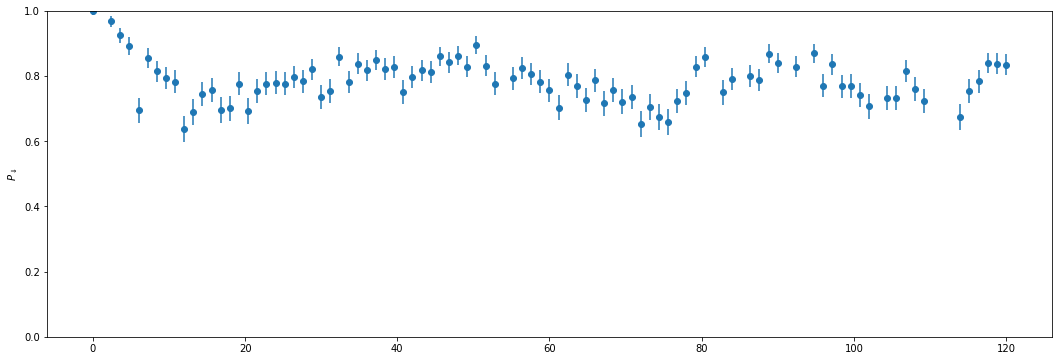

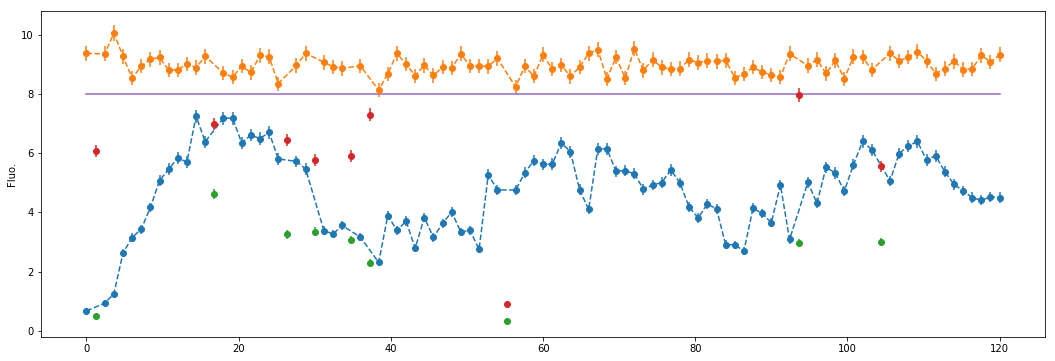

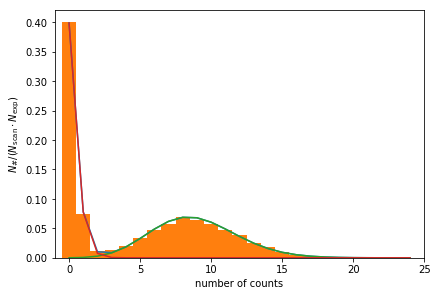

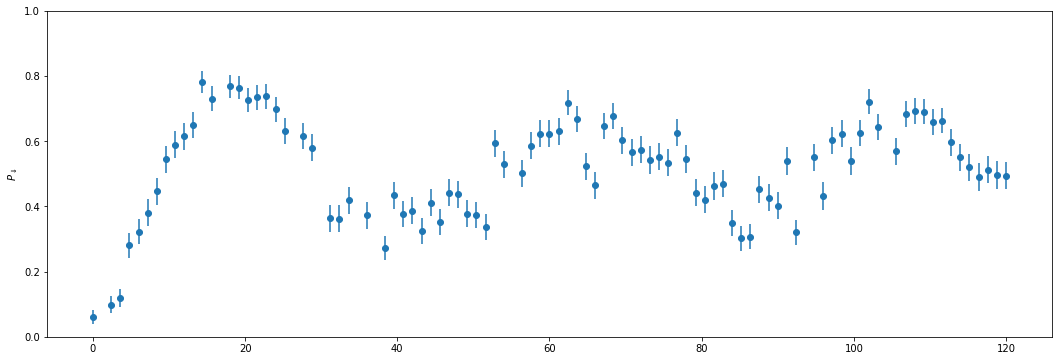

In [18]:
redflop = read_EIOS_file(fn[0], sort=False, skip_first=False, fluo_cut=8.5, hist_analysis=True, do_plot=True);
blueflop = read_EIOS_file(fn[1], sort=False, skip_first=False, fluo_cut=8.0, hist_analysis=True, do_plot=True);

FCN = 337.07298500147124 
 TOTAL NCALL = 1129 
 NCALLS = 1129 
 
 
 EDM = 4.38213236187418e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Rabi,0.158019,0.000585997,0,0,0.0,,
2,dec,0.00981587,0.000666598,0,0,0.0,,
3,limb,0.534783,0.0091872,0,0,0.0,1.0,
4,limr,0.770612,0.0101732,0,0,0.0,1.0,
5,p0,0.184962,0.078017,0,0,0.0,1.0,
6,p1,0.0551721,0.0235613,0,0,0.0,1.0,
7,p2,0.0222521,0.0101351,0,0,0.0,1.0,
8,p3,0.0147946,0.00736205,0,0,0.0,1.0,
9,p4,0.00182284,0.00430122,0,0,0.0,1.0,
10,p5,0.00353126,0.00527317,0,0,0.0,1.0,


1.9827822647145368

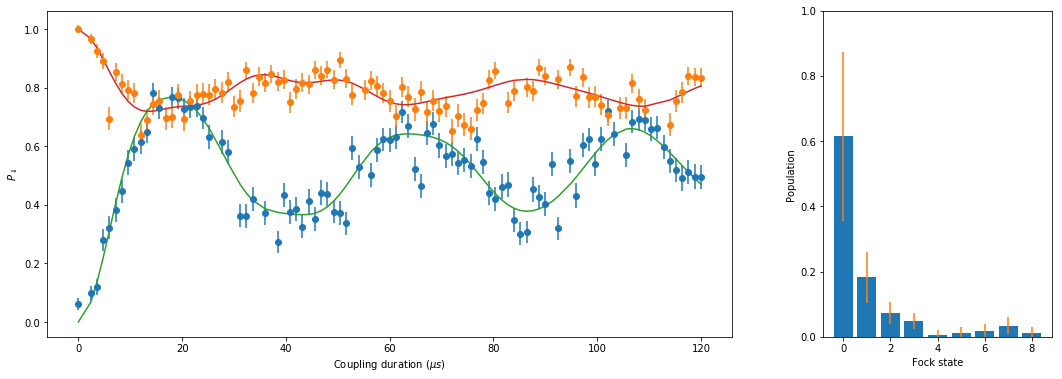

In [19]:
[tdatabsb, flopdatabsb, errsbsb] = blueflop;
[tdatarsb, flopdatarsb, errsrsb] = redflop;

LD = 0.15

def fit_function_freepops(Rabi, dec, limb, limr, p0, p1, p2, p3, p4, p5, p6, p7, p8):

    fockdist = [[0,p0],[1,p1],[2,p2],[3,p3],[4,p4],[5,p5],[6,p6],[7,p7],[8,p8]]
    fockdistnorm = normalizefockdist(fockdist)
        
    modelBSB = OCFlop1Mdec(LD, fockdistnorm, Rabi, dec, limb, 1, tdatabsb);
    modelRSB = OCFlop1Mdec(LD, fockdistnorm, Rabi, dec, limr, -1, tdatarsb);

    residBSB = (flopdatabsb - modelBSB)**2/errsbsb**2
    residRSB = (flopdatarsb - modelRSB)**2/errsrsb**2
    return sum(residBSB)+sum(residRSB)

m = Minuit(fit_function_freepops,
          Rabi=0.14, dec=0.002, limb=0.55, limr=0.85, p0=0.9, p1=0.05, p2=0.05, p3=0.0, p4=0.0, p5=0.0, p6=0.0, p7=0.0, p8=0.0,
          error_Rabi=0.01, error_dec=0.0001, error_limb=0.1, error_limr=0.1, error_p0=0.001, error_p1=0.001, error_p2=0.001, error_p3=0.001, error_p4=0.0001, error_p5=0.0001, error_p6=0.0001, error_p7=0.0001, error_p8=0.0001,
          limit_p0 = (0,1), limit_p1 = (0,1), limit_p2 = (0,1), limit_p3 = (0,1), limit_p4 = (0,1), limit_p5 = (0,1), limit_p6 = (0,1), limit_p7 = (0,1), limit_p8 = (0,1), 
          limit_limb = (0,1), limit_limr = (0,1), limit_Rabi=(0,None), limit_dec=(0,None),
          errordef = 1)

fmin, param = m.migrad(ncall=100000)

fitrabi=m.values['Rabi']
fitdec=m.values['dec']
fitlimb=m.values['limb']
fitlimr=m.values['limr']
fitp0=m.values['p0']
fitp1=m.values['p1']
fitp2=m.values['p2']
fitp3=m.values['p3']
fitp4=m.values['p4']
fitp5=m.values['p5']
fitp6=m.values['p6']
fitp7=m.values['p7']
fitp8=m.values['p8']
fitfockdist = [[0,fitp0],[1,fitp1],[2,fitp2],[3,fitp3],[4,fitp4],[5,fitp5],[6,fitp6],[7,fitp7],[8,fitp8]]
fitsum=sum([item[1] for item in fitfockdist])
fitp0err=m.errors['p0']/fitsum
fitp1err=m.errors['p1']/fitsum
fitp2err=m.errors['p2']/fitsum
fitp3err=m.errors['p3']/fitsum
fitp4err=m.errors['p4']/fitsum
fitp5err=m.errors['p5']/fitsum
fitp6err=m.errors['p6']/fitsum
fitp7err=m.errors['p7']/fitsum
fitp8err=m.errors['p8']/fitsum

fitfockdisterrs = [fitp0err,fitp1err,fitp2err,fitp3err,fitp4err,fitp5err,fitp6err,fitp7err,fitp8err]
fitfockdistnorm = normalizefockdist(fitfockdist)
fitpops = [item[1] for item in fitfockdistnorm]
fitns = [item[0] for item in fitfockdistnorm]

cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,2,figsize=(18,6), gridspec_kw = {'width_ratios':[3, 1]});
ax[0].errorbar(tdatabsb, flopdatabsb, yerr = errsbsb, linestyle = "None", marker = "o");
ax[0].errorbar(tdatarsb, flopdatarsb, yerr = errsrsb, linestyle = "None", marker = "o");
ax[0].plot(tdatabsb, OCFlop1Mdec(LD, fitfockdistnorm, fitrabi, fitdec, fitlimb, 1, tdatabsb))
ax[0].plot(tdatarsb, OCFlop1Mdec(LD, fitfockdistnorm, fitrabi, fitdec, fitlimr, -1, tdatarsb))
ax[0].set_xlabel('Coupling duration ($\mu s$)', fontsize=10)
ax[0].set_ylabel('$P_\Downarrow$', fontsize=10);
ax[1].bar(fitns, fitpops, width=0.8, align = 'center');
ax[1].errorbar(fitns, fitpops, yerr = fitfockdisterrs,marker = 'None', linestyle = 'None', color = cmap(1));
ax[1].set_xlabel('Fock state')
ax[1].set_ylabel('Population')
ax[1].set_ylim(0,1);
fmin.fval / (len(flopdatabsb)+len(flopdatarsb) - 13)